# Chapter 10: Control I – Classical Feedback
This chapter introduces the fundamentals of classical feedback control, focusing on single-input single-output (SISO) systems. It covers the anatomy of control loops, stability analysis, and tuning of PID controllers using root-locus and frequency-domain methods. Emphasis is placed on practical Python simulations using the control library, with applications to space engineering examples like satellite attitude control. The chapter assumes familiarity with differential equations and builds on model classification from earlier units.




## 1. Introduction to Feedback Control
Control systems are ubiquitous in engineering, enabling precise regulation of dynamic processes despite uncertainties and disturbances. In the context of space engineering, control is essential for tasks such as satellite attitude adjustment, orbit maintenance, and spacecraft docking. This section distinguishes between open-loop and closed-loop control strategies and connects them to concepts from earlier chapters.

> **Definition:** **Open-loop control** refers to systems where the input to the process (or "plant") is determined solely based on a predefined model or schedule, without measuring the actual output.
>



For example, a simple timer-based thruster firing sequence for a satellite assumes perfect knowledge of dynamics and no external perturbations like gravitational variations or solar radiation pressure. Mathematically, if the plant is described by a transfer function $G(s)$ (introduced later via Laplace transforms), the output $Y(s)$ is simply $Y(s) = G(s) U(s)$, where $U(s)$ is the input. Open-loop systems are straightforward but sensitive to model inaccuracies and unmodeled disturbances, leading to poor performance in real-world scenarios.

> **Definition:** **Closed-loop control**, in contrast, also known as feedback control, incorporates measurements of the output to compute an error signal, which is then used to adjust the input dynamically. This acts as an error correction mechanism: the controller compares the measured output $y(t)$ with a desired reference (setpoint) $r(t)$ to form the error $e(t) = r(t) - y(t)$, and generates a control action $u(t)$ to minimize $e(t)$. The closed-loop transfer function becomes $Y(s) = \frac{G(s) C(s)}{1 + G(s) C(s)} R(s)$, where $C(s)$ is the controller. Feedback enhances robustness, allowing systems to reject disturbances and track setpoints accurately, even with model uncertainties.



Recalling Chapter 2 on model classification and degrees of freedom (DOF) analysis, feedback control can be viewed through the lens of **control degrees of freedom** ($N_{FC}$), which represent the maximum number of process variables that can be independently controlled. Unlike the overall system DOF ($N_F$), which determines whether a model is under-determined, well-determined, or over-determined for simulation purposes (e.g., ensuring a unique solution to the governing equations), control DOF focuses specifically on the number of independent input variables that can be manipulated—often equaling $N_{FC}$ in practical scenarios. The relationship $N_F = N_{FC} + N_D$ highlights how the total system DOF accounts for both controllable inputs and disturbance variables ($N_D$), where disturbances are external factors like solar radiation pressure on a satellite or gravitational perturbations in orbit that affect the system but cannot be directly manipulated.

In an open-loop system, even if the model is fully determined for simulation (i.e., $N_F = 0$ at steady-state with balanced equations), available control DOF may go unused, leaving the system vulnerable to disturbances that shift outputs away from desired values. For instance, a spacecraft's attitude might be modeled as a well-determined dynamic system based on Newton's laws, but without active control, disturbances like atmospheric drag could cause drift. Closed-loop feedback control leverages these control DOF by designating manipulated variables (MVs), such as thruster firings or reaction wheel torques, to adjust in response to measured errors in controlled variables (CVs), like orientation angles or orbital position. The controller aims to maintain CVs at their setpoints despite disturbances, effectively using feedback to "close the loop" and enhance robustness. This distinction is crucial in space engineering: for a satellite with multiple actuators (e.g., reaction wheels for fine attitude control and thrusters for coarser adjustments), the control DOF ensures we can independently manipulate enough inputs to handle multi-axis rotations, while respecting constraints like conservation of angular momentum. Over-specifying MVs (e.g., redundant actuators) can provide fault tolerance without over-determining the simulation model, as long as the control strategy resolves any potential conflicts.



### 1.1 History of control engineering
The development of control engineering spans millennia, evolving from mechanical ingenuity to sophisticated mathematical frameworks, with significant applications in space systems today.

Early examples date back to ancient civilizations, such as the water clocks (clepsydrae) used in Ancient Greece around 300 BCE, which employed float valves to maintain constant flow rates as a rudimentary form of level control. By the 17th century, Cornelis Drebbel's incubator (circa 1620) used a thermostat-like mechanism to regulate temperature via feedback from a mercury thermometer controlling a damper.

A pivotal advancement came during the Industrial Revolution with James Watt's centrifugal governor in 1788, designed to regulate steam engine speed. As engine speed increased, rotating balls rose due to centrifugal force, throttling steam input to maintain equilibrium. This mechanical feedback device stabilized output despite load variations, marking a cornerstone of automatic control.



In the early 20th century, pre-digital controls relied on pneumatic and hydraulic systems for industrial processes like chemical plants and refineries. Pioneers like Elmer Sperry (1910s) applied gyroscopic feedback for ship steering and aircraft autopilots, laying groundwork for aerospace applications. World War II accelerated progress, with the need for precise anti-aircraft gun pointing and radar tracking leading to electronic amplifiers and servomechanisms. Additionally, wartime missile guidance systems, such as the gyroscopic autopilots in the German V-1 cruise missile and the inertial navigation with analog computers in the V-2 rocket, advanced feedback control for rocketry, influencing post-war developments in ballistic missiles and space vehicles. Engineers like Harold Black (1927) invented negative feedback amplifiers to reduce distortion, enabling reliable signal processing.

Mathematical formalization transformed the field into the control theory that we study in the modern day. Hendrik Bode and Harry Nyquist at Bell Labs developed frequency-domain analysis in the 1930s–1940s: Nyquist's stability criterion (1932) used contour plots to assess closed-loop stability, while Bode plots (1940) visualized gain and phase margins. Simultaneously, the adoption of Laplace transforms (originally by Pierre-Simon Laplace in the 1780s but popularized in engineering by Oliver Heaviside) allowed conversion of differential equations into algebraic forms. Transfer functions $G(s)$ enabled frequency-domain design, simplifying analysis of dynamic systems without time-domain simulations.

By the 1950s, these tools underpinned classical control theory, influencing space engineering from the Sputnik era onward. Today, they form the basis for digital implementations in satellites and rockets, bridging to modern methods like model predictive control covered in later chapters.



### 1.2 The Laplace transform

The Laplace transform is a powerful mathematical tool for analyzing linear time-invariant (LTI) systems, particularly in control engineering. It converts differential equations in the time domain into algebraic equations in the complex frequency domain, simplifying the solution of dynamic problems. This is especially useful in space engineering for modeling systems like satellite vibrations or orbital dynamics, where solving ODEs directly can be cumbersome.

> **Definition:** The (unilateral) **Laplace transform** of a function $f(t)$ (assuming $f(t) = 0$ for $t < 0$) is:
>
> $$\mathcal{L}\{f(t)\} = F(s) = \int_0^\infty f(t) e^{-st} \, dt,$$
>
> where $s = \sigma + j\omega$ is a complex variable, with $\sigma$ as the real part (damping factor) and $\omega$ as the imaginary part (frequency). The transform exists only if the integral converges, which depends on the choice of $\sigma$.


Another important definition in control theory is the concept of a transfer function:

> **Definition:** The **transfer function $G(s)$** of an LTI system is defined as the ratio of the Laplace transform of the output $Y(s)$ to the Laplace transform of the input $U(s)$, assuming zero initial conditions:
>
> $$ G(s) = \frac{Y(s)}{U(s)}. $$
>
> It represents the system's input-output relationship in the s-domain, encapsulating dynamics like amplification, filtering, or delay.


In control theory, the transfer function is used to analyze system behavior algebraically: stability is assessed via pole locations (e.g., all poles in the left-half plane for asymptotic stability), frequency responses are visualized with Bode plots for tuning margins, and controllers (e.g., PID) are designed to shape the closed-loop transfer function for desired performance, such as reduced overshoot or faster settling in spacecraft control loops.

In general, we will work a lot in the **Laplace domain** (also called the **s-domain**) instead of the time domain. One reason for this is because it becomes a lot easier to perform stability analysis. A healthy interpretation of a convergent Laplace integral is to think of it informally as a finite scalar value $F(s)$ representing a dynamic function $f(t)$. The difference is that $F(s)$ follows a simpler algebra that we can use to solve ODE systems, perform stability analyses etc. as demonstrated in the following subsection.



### 1.3 Geometric Demonstration of Convergence

To understand why the Laplace transform works for oscillating or growing functions, consider the role of the exponential decay term $e^{-\sigma t}$. For functions that oscillate indefinitely, like $\sin(\omega t)$, the integral without decay ($\sigma = 0$) may not converge because the oscillations do not die out. However, a positive $\sigma$ introduces damping, ensuring the integrand approaches zero as $t \to \infty$, leading to a finite integral.

Let's demonstrate this geometrically with plots. We'll use Python's matplotlib to visualize the integrand for $f(t) = \sin(2\pi t)$ (an oscillating function with frequency 1 Hz) multiplied by $e^{-st}$, focusing on the magnitude envelope since the complex exponential $e^{-j\omega t}$ adds rotation but not decay. For simplicity, set $\omega = 0$ in the plots to isolate the damping effect.

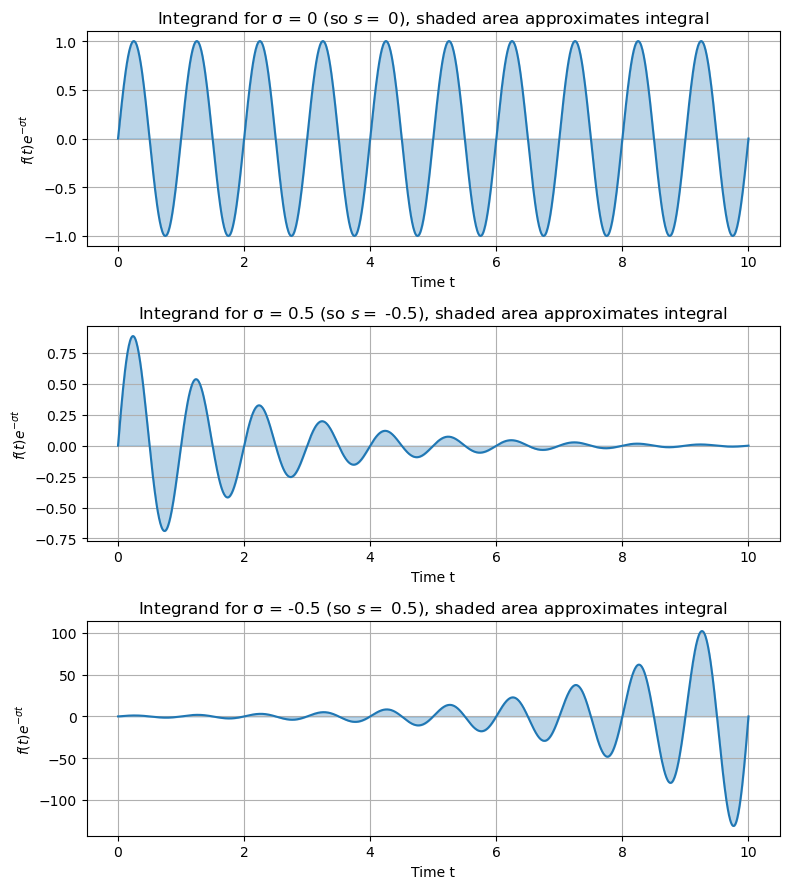

In [57]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 10, 1000)  # Time from 0 to 10 seconds (approximating infinity for illustration)
omega_f = 2 * np.pi  # Frequency of sine wave (1 Hz)
f_t = np.sin(omega_f * t)  # f(t) = sin(2 pi t)

# Plot for different sigma values
sigmas = [0, 0.5, -0.5]  # sigma = 0 (no decay), >0 (decay), <0 (growth)
fig, axs = plt.subplots(3, 1, figsize=(8, 9))

for i, sigma in enumerate(sigmas):
    integrand = f_t * np.exp(-sigma * t)  # Real part approximation (ignoring j omega for visualization)
    axs[i].plot(t, integrand, color='tab:blue')
    axs[i].fill_between(t, integrand, color='tab:blue', alpha=0.3)  # Shade the area under the curve
    axs[i].set_title(f'Integrand for σ = {sigma}' + f' (so $s =$ {-sigma}$)$' + ', shaded area approximates integral')
    axs[i].set_xlabel('Time t')
    axs[i].set_ylabel(r'$f(t) e^{-σ t}$')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In the plot:

- For $\sigma = 0$, the integrand oscillates without bound, and the integral from 0 to $\infty$ does not converge.
- For $\sigma > 0$ (e.g., 0.5), the amplitude decays exponentially, ensuring convergence.
- For $\sigma < 0$ (e.g., -0.5), the amplitude grows, leading to divergence.

To confirm convergence numerically, we can approximate the integral for $\sin(\omega t)$:
The analytical Laplace transform is $\mathcal{L}\{\sin(\omega t)\} = \frac{\omega}{s^2 + \omega^2}$, which converges for $\operatorname{Re}(s) > 0$.

In [2]:
from scipy.integrate import quad

def integrand_real(t, sigma, omega_f, omega_s=0):
    return np.sin(omega_f * t) * np.exp(-sigma * t) * np.cos(omega_s * t)  # Real part

def integrand_imag(t, sigma, omega_f, omega_s=0):
    return np.sin(omega_f * t) * np.exp(-sigma * t) * (-np.sin(omega_s * t))  # Imag part

# Numerical integration for s = sigma + j*0, omega_f = 2*pi
sigma = 0.5
integral_real, _ = quad(integrand_real, 0, np.inf, args=(sigma, 2*np.pi))
integral_imag, _ = quad(integrand_imag, 0, np.inf, args=(sigma, 2*np.pi))
print(f'Numerical F(s) for s={sigma}: {integral_real} + {integral_imag}j')
# Analytical: omega / (sigma^2 + omega^2) + 0j (since omega_s=0)
print(f'Analytical: {2*np.pi / (sigma**2 + (2*np.pi)**2)}')

Numerical F(s) for s=0.5: 0.15815342426634238 + 0.0j
Analytical: 0.1581534248293454


This code shows the numerical integral matches the analytical result for $\sigma > 0$, but would fail (diverge) for $\sigma \leq 0$.


### 1.4 Region of Convergence (ROC)

The region of convergence (ROC) is the set of values of $s$ in the complex plane for which the integral converges. For right-sided signals (common in control, where $f(t) = 0$ for $t < 0$), the ROC is typically a half-plane to the right of the rightmost pole of $F(s)$. For example:

- For $f(t) = e^{a t}$ (exponential growth if $a > 0$), ROC is $\operatorname{Re}(s) > a$.
- For $\sin(\omega t)$, poles at $s = \pm j\omega$, so ROC is $\operatorname{Re}(s) > 0$.

The ROC is crucial for uniqueness: the same $F(s)$ can correspond to different $f(t)$ depending on the ROC. In control, we often assume causal systems, so ROC is $\operatorname{Re}(s) > \sigma_0$ for some $\sigma_0$.

We can illustrate the ROC conceptually with a pole-zero plot, but for visualization, consider the complex plane where the vertical axis is $\omega$ and horizontal is $\sigma$; the ROC is shaded to the right of the boundary.



> #### Example: Solving Basic ODEs with Laplace Transforms
> The Laplace transform shines in solving ordinary differential equations (ODEs) by turning them into algebraic problems. Consider the mass-spring-damper system, a classic model for mechanical vibrations (e.g., a satellite's flexible solar panel or a spacecraft's suspension):
> The governing ODE is:
>
>
> $$ m \frac{d^2 y}{dt^2} + c \frac{dy}{dt} + k y(t) = f(t), $$
>
> with initial conditions $y(0) = y_0$, $\frac{dy}{dt}(0) = v_0$, where $m$ is mass, $c$ damping coefficient, $k$ spring constant, and $f(t)$ external force.
>
> Taking the Laplace transform (using properties: $\mathcal{L}\{\dot{y}\} = s Y(s) - y(0)$, $\mathcal{L}\{\ddot{y}\} = s^2 Y(s) - s y(0) - \dot{y}(0)$):
>
> $$m (s^2 Y(s) - s y_0 - v_0) + c (s Y(s) - y_0) + k Y(s) = F(s).$$
>
> Solving for $Y(s)$:
>
> $$Y(s) = \frac{F(s) + (m s + c) y_0 + m v_0}{(m s^2 + c s + k)}.$$
>
> This is algebraic: no need to solve the ODE directly. To find $y(t)$, take the inverse Laplace transform $\mathcal{L}^{-1}\{Y(s)\}$. We can use Python's sympy library to compute this symbolically. Let's assume $f(t) = 0$ (free response), $m=1$, $c=0.5$, $k=1$, $y_0=1$, $v_0=0$:

In [3]:
import sympy as sp

s, t = sp.symbols('s t')
m, c, k = 1, 0.5, 1
y0, v0 = 1, 0
F_s = 0  # No external force

# Algebraic equation
numer = F_s + (m*s + c)*y0 + m*v0
denom = m*s**2 + c*s + k
Y_s = numer / denom
print('Y(s) =', Y_s)

# Inverse Laplace
y_t = sp.inverse_laplace_transform(Y_s, s, t)
print('y(t) =', y_t)

Y(s) = (s + 0.5)/(s**2 + 0.5*s + 1)
y(t) = (0.258198889747161*exp(-0.25*t)*sin(0.968245836551854*t) + 1.0*exp(-0.25*t)*cos(0.968245836551854*t))*Heaviside(t)


This yields $Y(s) = \frac{s + 0.5}{s^2 + 0.5 s + 1}$, and the inverse is $y(t) = e^{-0.25 t} \left( \cos\left(\frac{\sqrt{3}}{4} t\right) + \frac{\sqrt{3}}{3} \sin\left(\frac{\sqrt{3}}{4} t\right) \right)$ (for $t \geq 0$), showing damped oscillations.

In practice, for numerical solutions or complex systems, we use libraries like scipy.signal for transfer functions, but the Laplace approach provides insight into system poles and stability, as explored next.

### 1.5 Control loop anatomy
Control loops form the backbone of feedback systems, enabling automatic regulation of processes in engineering applications. In space engineering, a control loop might manage a satellite's orientation by continuously adjusting reaction wheels based on gyroscope readings. This subsection outlines the key components of a typical feedback control loop, presents its block diagram representation, and discusses external influences like disturbances and noise, along with common performance metrics.
Components of a Control Loop

A standard feedback control loop consists of the following interconnected elements:

- **Reference input (setpoint)**, $r(t)$: The desired value or trajectory for the system's output. For example, in satellite attitude control, this could be the target pointing direction toward Earth.
- **Error signal**, $e(t)$: The difference between the reference and the measured output, calculated as $e(t) = r(t) - y(t)$. This quantifies how far the system is from its goal.
- **Controller:** A computational or physical device that processes the error signal to generate a control command. Common types include PID controllers (detailed in Section 3), which amplify, integrate, or differentiate the error to produce an appropriate response.
- **Actuator:** The mechanism that converts the controller's command into physical action. In space systems, this might be thrusters, reaction wheels, or magnetic torquers that apply torque to adjust the spacecraft's attitude.
- **Plant/process:** The system being controlled, described by its dynamics (e.g., the spacecraft's rigid body equations of motion). Mathematically, often represented by a transfer function $G(s)$ in the Laplace domain.
- **Sensor:** Measures the plant's output $y(t)$ and feeds it back. Sensors introduce potential inaccuracies, such as noise from gyroscope drift in space applications.
- **Feedback path:** Closes the loop by routing the sensor output back to the error calculation, enabling continuous correction.

These components work together to minimize the error over time, making the system robust to uncertainties.

#### Block Diagram Representation
Control loops are visualized using block diagrams, where blocks represent components and arrows indicate signal flow. The standard form is the unity-feedback loop, where the feedback gain is 1 (i.e., direct subtraction of the output from the reference). Here's a simple block diagram for a unity-feedback system:

Reference $R(s)$ → Summing junction (error $E(s) = R(s) - Y(s)$) → Controller $C(s)$ → Plant $G(s)$ → Output $Y(s)$ → Feedback to summing junction.

To generate this diagram in Python, we can use matplotlib to draw boxes, arrows, and labels manually (as the control library focuses on analysis rather than diagramming). The code below creates a visual representation:






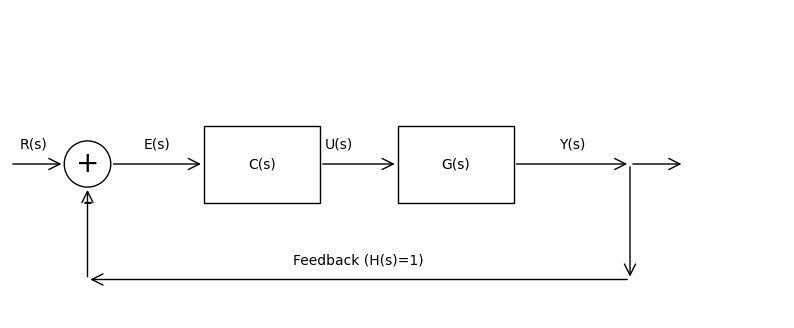

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(0, 10)
ax.set_ylim(0, 4)
ax.axis('off')  # Hide axes

# Summing junction (circle)
ax.add_patch(plt.Circle((1, 2), 0.3, fill=False))
ax.text(1, 2, '+', ha='center', va='center', fontsize=20)
ax.text(1, 1.5, '-', ha='center', va='center', fontsize=20)

# Controller block
ax.add_patch(Rectangle((2.5, 1.5), 1.5, 1, fill=False))
ax.text(3.25, 2, 'C(s)', ha='center', va='center')

# Plant block
ax.add_patch(Rectangle((5, 1.5), 1.5, 1, fill=False))
ax.text(5.75, 2, 'G(s)', ha='center', va='center')

# Arrows
ax.add_patch(FancyArrowPatch((0, 2), (0.7, 2), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((1.3, 2), (2.5, 2), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((4, 2), (5, 2), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((6.5, 2), (8, 2), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((8, 2), (8, 0.5), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((8, 2), (8.7, 2), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((8, 0.5), (1, 0.5), arrowstyle='->', mutation_scale=20))
ax.add_patch(FancyArrowPatch((1, 0.5), (1, 1.7), arrowstyle='->', mutation_scale=20))

# Labels
ax.text(0.3, 2.2, 'R(s)', ha='center')
ax.text(1.9, 2.2, 'E(s)', ha='center')
ax.text(4.25, 2.2, 'U(s)', ha='center')
ax.text(7.25, 2.2, 'Y(s)', ha='center')
ax.text(4.5, 0.7, 'Feedback (H(s)=1)', ha='center')

plt.show()


This code produces a block diagram illustrating the unity-feedback loop.

Real-world systems face external influences that challenge control performance:

- Disturbances: Uncontrolled inputs affecting the plant, such as solar wind on a satellite's orbit. Denoted as $d(t)$, they add to the plant input or output, requiring the controller to compensate.
- Noise: Measurement errors from sensors, like thermal noise in star trackers. Modeled as $n(t)$ added to the feedback signal, noise can cause unnecessary control actions if not filtered.

To evaluate a control loop's effectiveness, we use step response metrics (response to a unit step input, simulating a sudden setpoint change):

Rise time ($t_r$): Time to go from 10% to 90% of the final value; measures responsiveness.
Overshoot: Percentage the output exceeds the setpoint; high overshoot indicates underdamping.
Settling time ($t_s$): Time for the response to stay within ±2% (or ±5%) of the final value; reflects stability.
Steady-state error ($e_{ss}$): Persistent error as $t \to \infty$; ideally zero for tracking setpoints.

These can be visualized via simulation. Using the control library, here's code for a unity-feedback system's step response (e.g., a second-order plant $G(s) = \frac{1}{s^2 + s + 1}$ with proportional controller $C(s) = 5$):

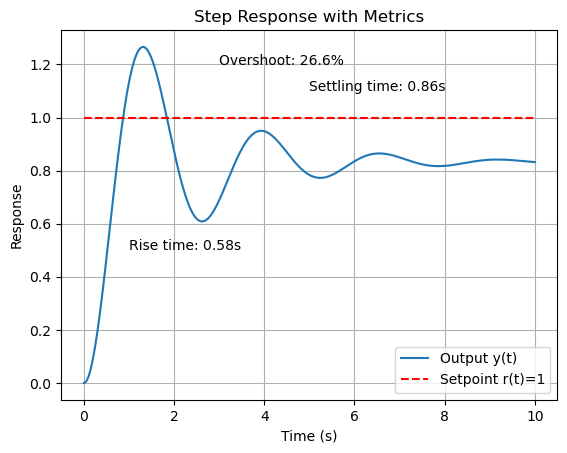

In [5]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Define plant and controller
G = ct.tf([1], [1, 1, 1])  # G(s) = 1 / (s^2 + s + 1)
C = ct.tf([5], [1])       # Proportional gain K=5

# Closed-loop transfer function (unity feedback)
sys_cl = ct.feedback(C * G, 1)

# Simulate step response
t = np.linspace(0, 10, 1000)
t_out, y_out = ct.step_response(sys_cl, t)

# Plot
plt.plot(t_out, y_out, label='Output y(t)')
plt.plot(t_out, np.ones_like(t_out), 'r--', label='Setpoint r(t)=1')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Step Response with Metrics')
plt.grid(True)
plt.legend()

# Annotate metrics (approximate calculations)
rise_time = t[np.where(y_out >= 0.9)[0][0]] - t[np.where(y_out >= 0.1)[0][0]]
overshoot = (max(y_out) - 1) * 100
settling_time = t[np.where(np.abs(y_out - 1) <= 0.02)[0][0]]  # First time within 2%
plt.annotate(f'Rise time: {rise_time:.2f}s', xy=(1, 0.5))
plt.annotate(f'Overshoot: {overshoot:.1f}%', xy=(3, 1.2))
plt.annotate(f'Settling time: {settling_time:.2f}s', xy=(5, 1.1))
plt.show()

This simulation highlights how feedback improves performance compared to open-loop, reducing steady-state error and handling disturbances, though tuning (e.g., via PID) is needed to optimize metrics. In space applications, low overshoot is critical to avoid structural stress, while fast settling ensures quick recovery from perturbations.

### 1.6 Basic control loop example

To illustrate the principles of feedback control, let's simulate a simple second-order plant representing a dynamic system. A second-order model is common in engineering, such as the attitude dynamics of a spacecraft or the response of a mechanical system to inputs. Here, we'll use the plant transfer function $  G(s) = \frac{1}{s^2 + s + 1}  $, which could approximate the rotational dynamics of a satellite around one axis, where the denominator terms represent inertia, damping (e.g., from gyroscopic effects), and stiffness (e.g., from gravitational gradients).

We'll compare the open-loop response (no feedback) to the closed-loop response with a simple proportional controller (gain $  K_p = 5  $) in a unity-feedback configuration. The input is a unit step, simulating a sudden command like a desired change in orbital position. Simulations use Python's control library to compute and plot step responses, highlighting how feedback improves tracking, reduces steady-state error, and enhances stability.

In space engineering, this ties into basic thruster control for orbit adjustment: open-loop might fire thrusters based on a precomputed schedule, but disturbances like atmospheric drag cause drift. Closed-loop feedback uses sensors (e.g., GPS) to measure position error and adjust thruster firing proportionally, maintaining the orbit more accurately.


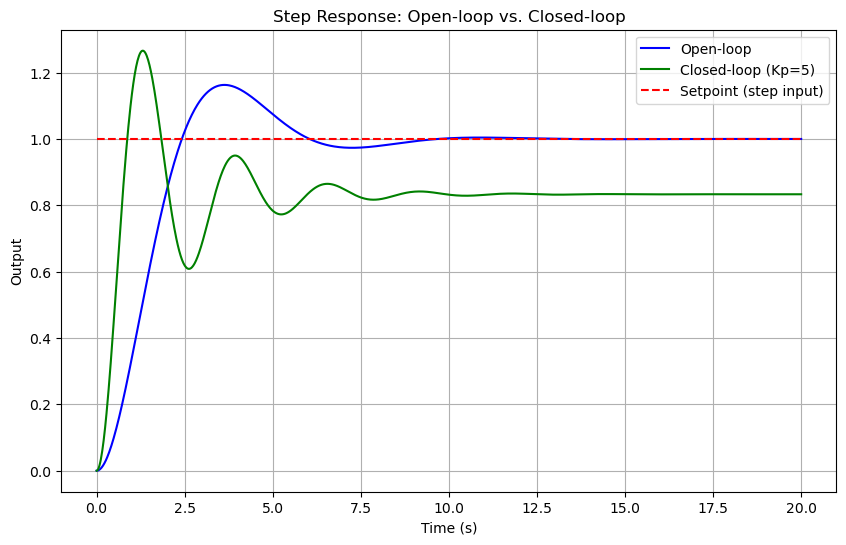

In [6]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Define the plant G(s) = 1 / (s^2 + s + 1)
G = ct.tf([1], [1, 1, 1])

# Open-loop system: just the plant
sys_ol = G

# Closed-loop system: proportional controller Kp=5 with unity feedback
Kp = 5
C = ct.tf([Kp], [1])
sys_cl = ct.feedback(C * G, 1)

# Time vector for simulation
t = np.linspace(0, 20, 1000)

# Step response for open-loop
t_ol, y_ol = ct.step_response(sys_ol, t)

# Step response for closed-loop
t_cl, y_cl = ct.step_response(sys_cl, t)

# Plot responses
plt.figure(figsize=(10, 6))
plt.plot(t_ol, y_ol, label='Open-loop', color='blue')
plt.plot(t_cl, y_cl, label='Closed-loop (Kp=5)', color='green')
plt.plot(t, np.ones_like(t), 'r--', label='Setpoint (step input)')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Step Response: Open-loop vs. Closed-loop')
plt.legend()
plt.grid(True)
plt.show()

In the plot above (which will appear when running this notebook), the open-loop response approaches a steady-state value of 1 but slowly, with oscillations due to the underdamped poles. The closed-loop response, however, settles faster with reduced overshoot and zero steady-state error for this type (thanks to the proportional gain amplifying the error correction). Increasing $K_p$ would speed up the response but risks instability if too high: a trade-off explored in later sections on stability and tuning.

For the orbit adjustment example, imagine the output $y(t)$ as the spacecraft's position deviation from the target orbit. Open-loop control might undershoot or drift, while closed-loop ensures precise station-keeping, crucial for geostationary satellites. This basic setup paves the way for more advanced controllers like PID in Section 3.

### (Optional) 1.7 Step by step demonstration on finding analytical solution in linear system

#### Example: Simple ODE Control Loop Example
> Let's revisit solving the basic closed-loop control system using Laplace transforms, now with adjustments: we'll use Leibniz notation for derivatives (e.g., $\frac{dy}{dt}$) and provide a table of the key Laplace transforms upfront.
>
> **Description of system:**
>
> Plant dynamics:
> The open-loop system is
>
> $$\frac{dy}{dt} = -a y(t) + u(t), $$
>
> where $y(t)$ is the output, $u(t)$ is the control input, and $a > 0$ is a parameter.
>
> Controller: Proportional feedback,
>
> $$u(t) = K (r(t) - y(t)), $$
>
> with $K > 0$ the gain and $r(t)$ the reference.
>
> Closed-loop ODE:
> Substituting gives:
>
> $$\frac{dy}{dt} = -a y(t) + K (r(t) - y(t)) = -(a + K) y(t) + K r(t)$$
>
> or:
>
> $$\frac{dy}{dt} + (a + K) y(t) = K r(t)$$
>
> Input and initial condition: Unit step $r(t) = \mathcal{U}(t)$ (1 for $t \geq 0$, 0 otherwise), $y(0) = 0$.
>
> **Table of Laplace Transforms Used:**
>
> Before solving, here is a table of the specific transforms and properties we'll apply:
>
> | Function or Property          | Time Domain                                      | Laplace Domain       |
> |-------------------------------|--------------------------------------------------|----------------------|
> | Derivative                    | $\frac{dy}{dt}$                                  | $sY(s) - y(0)$      |
> | Constant multiple             | $c f(t)$ (where $c$ is constant)                 | $c F(s)$             |
> | Addition                      | $f(t) + g(t)$                                    | $F(s) + G(s)$        |
> | Unit step                     | $u(t)$                                           | $\frac{1}{s}$        |
> | Exponential decay             | $e^{-b t} u(t)$ (where $b > 0$)                  | $\frac{1}{s + b}$    |
> | Shifted unit step (inverse)   | $\mathcal{L}^{-1} \left\{ \frac{1}{s} \right\} = u(t)$ | -                    |
> | Shifted exponential (inverse) | $\mathcal{L}^{-1} \left\{ \frac{1}{s + b} \right\} = e^{-b t} u(t)$ | -                    |
>
>
> **Solution:**
>
> **Step 1: Take the Laplace Transform of the ODE**
>
> Using the derivative property (with $y(0) = 0$) and linearity:
>
> $$s Y(s) + (a + K) Y(s) = K R(s)$$
>
> For $r(t) = \mathcal{U}(t)$, $R(s) = \frac{1}{s}$, so:
>
> $$s Y(s) + (a + K) Y(s) = K \cdot \frac{1}{s}$$
>
> **Step 2: Solve for $Y(s)$**
>
>  Factor $Y(s)$:
>
> $$Y(s) (s + a + K) = \frac{K}{s}$$
>
> $$Y(s) = \frac{K}{s (s + a + K)}$$
>
> **Step 3: Partial Fraction Decomposition**
>
> Decompose:
>
> $$\frac{K}{s (s + a + K)} = \frac{A}{s} + \frac{B}{s + a + K}$$
>
> $$K = A (s + a + K) + B s$$
>
> - At $s = 0$: $K = A (a + K) \implies A = \frac{K}{a + K}$
> - At $s = - (a + K)$: $K = B (- (a + K)) \implies B = -\frac{K}{a + K}$
>
> $$Y(s) = \frac{K}{a + K} \left( \frac{1}{s} - \frac{1}{s + a + K} \right)$$
>
> **Step 4: Inverse Laplace Transform**
>
> Using the inverse transforms from the table:
>
> $$y(t) = \frac{K}{a + K} \left( \mathcal{U}(t) - e^{-(a + K) t} \mathcal{U}(t) \right)$$
>
> For $t \geq 0$:
>
> $$y(t) = \frac{K}{a + K} \left( 1 - e^{-(a + K) t} \right)$$
>
> Numerical Example
> With $a = 1$, $K = 1$:
>
> $$y(t) = \frac{1}{2} \left( 1 - e^{-2 t} \right) \quad (t \geq 0)$$
>

## 2. Stability

Stability is a fundamental property in control systems, ensuring that the system responds predictably and returns to a desired state despite inputs, disturbances, or initial conditions. In space engineering, stability is critical for missions where uncertainties like variable gravitational fields or sensor noise could otherwise lead to mission failure, such as a satellite drifting out of its operational orbit. Two key concepts are bounded-input bounded-output (BIBO) stability and asymptotic stability.

> **Definition:** **BIBO stability**: A system is BIBO stable if every bounded input produces a bounded output. Mathematically, for a linear time-invariant (LTI) system, if the input $u(t)$ satisfies $|u(t)| \leq M < \infty$ for all $t$, then the output $y(t)$ also remains bounded, $|y(t)| \leq N < \infty$. This is determined by the system's impulse response: the system is BIBO stable if the integral of the absolute value of the impulse response is finite, $\int_{-\infty}^{\infty} |h(t)| \, dt < \infty$. In practice, BIBO ensures that small disturbances (e.g., micrometeoroid impacts on a spacecraft) do not cause unbounded growth in outputs like position errors.

> **Definition:** **Asymptotic stability:** A stronger condition where the system's state returns to equilibrium as $t \to \infty$, regardless of small initial perturbations. For LTI systems, this implies that free responses (zero input) decay to zero. In the context of uncertainties, asymptotic stability allows recovery from initial misalignments, such as a rocket's launch vibrations, ensuring long-term reliable operation.

These stability notions play a vital role in robust control design, allowing systems to operate safely under model inaccuracies, external disturbances, and noise—common in space environments where perfect modeling is impossible.






### 2.1 Stability in the s-domain (Laplace)
In the Laplace domain, stability analysis for continuous-time LTI systems is straightforward and leverages the transfer function's poles. The poles are the roots of the denominator polynomial of $G(s)$, and their locations in the complex s-plane determine the system's behavior.

> **Definition:** **Pole location criterion:** A system is asymptotically stable if all poles have negative real parts (i.e., lie in the left-half plane, Re(s) < 0). Poles on the imaginary axis indicate marginal stability (sustained oscillations), while right-half plane poles cause instability (exponential growth). BIBO stability aligns with this for strictly proper systems (degree of denominator > numerator). This criterion stems from the inverse Laplace transform: terms like $e^{st}$ decay if Re(s) < 0.

For example, consider:

- a **stable** second-order system $G(s) = \frac{1}{s^2 + 2s + 2}$ (poles at $-1 \pm j$),
- an **unstable** one $G(s) = \frac{1}{s^2 - s + 1}$ (one pole with positive real part), and
- a **marginally stable** one $G(s) = \frac{1}{s^2 + 1}$ (poles at $\pm j$).

We can visualize this using Python's control library with ct.pzmap to plot poles and zeros:


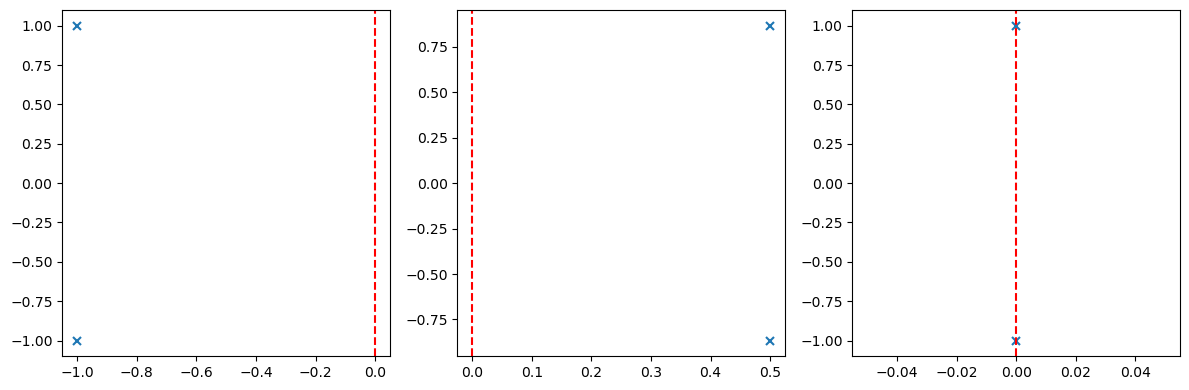

In [19]:
import control as ct
import matplotlib.pyplot as plt

# Define transfer functions
G_stable = ct.tf([1], [1, 2, 2])    # Poles: -1 ± j
G_unstable = ct.tf([1], [1, -1, 1]) # Poles: 0.5 ± √(0.75)j, one Re > 0
G_marginal = ct.tf([1], [1, 0, 1])  # Poles: ± j

# Plot pole-zero maps
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

ct.pzmap(G_stable, ax=axs[0], title='Stable')
axs[0].axvline(0, color='r', linestyle='--')  # Imaginary axis

ct.pzmap(G_unstable, ax=axs[1], title='Unstable')
axs[1].axvline(0, color='r', linestyle='--')

ct.pzmap(G_marginal, ax=axs[2], title='Marginally Stable')
axs[2].axvline(0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In the plots (generated when running this code), 'x' marks poles: left of the red dashed line (imaginary axis) for stability, right for instability, on the line for marginal cases.

> **Definition:** **Routh-Hurwitz criterion**: For higher-order systems, finding roots explicitly can be tedious. The Routh-Hurwitz criterion determines stability without solving the characteristic equation, by constructing a Routh array from the coefficients of the denominator polynomial and checking for sign changes in the first column. No sign changes (and no zero rows requiring special handling) imply all poles are in the left-half plane.

Consider a general third-order polynomial $s^3 + a s^2 + b s + c = 0$. The Routh array is:

$$\begin{array}{cc}
s^3 & 1 \quad b \\
s^2 & a \quad c \\
s^1 & \frac{a b - c}{a} \quad 0 \\
s^0 & c \quad 0 \\
\end{array}$$

Stability requires all first-column elements positive (assuming $a > 0$; otherwise, multiply by -1 and check for no sign changes).
For example, test $s^3 + 3s^2 + 3s + 1 = 0$ (stable, roots -1, -1, -1):

Routh array:

$$\begin{array}{cc}
s^3 & 1 \quad 3 \\
s^2 & 3 \quad 1 \\
s^1 & \frac{9 - 1}{3} = \frac{8}{3} \quad 0 \\
s^0 & 1 \quad 0 \\
\end{array}$$

All positive: no sign changes, stable.

Now, an unstable example: $s^3 + s^2 - s - 1 = 0$:

$$\begin{array}{cc}
s^3 & 1 \quad -1 \\
s^2 & 1 \quad -1 \\
s^1 & \frac{-1 - (-1)}{1} = 0 \quad 0 \\
s^0 & -1 \quad 0 \\
\end{array}$$

Zero in $s^1$ row requires handling (replace with epsilon, check limits), but ultimately sign change from 0 to -1 indicates instability.
We can implement the Routh array in Python using numpy for array manipulation, or use sympy for symbolic computation. Here's a numerical example using a simple function:


In [20]:
import numpy as np

def routh_hurwitz(coeffs):
    """Generate Routh array for polynomial coefficients [a_n, a_{n-1}, ..., a_0]"""
    n = len(coeffs)
    routh = np.zeros((n, (n + 1) // 2))
    routh[0, :len(coeffs[::2])] = coeffs[::2]
    routh[1, :len(coeffs[1::2])] = coeffs[1::2]

    for i in range(2, n):
        for j in range(routh.shape[1] - 1):
            routh[i, j] = -(routh[i-2, j] * routh[i-1, j+1] - routh[i-2, j+1] * routh[i-1, j]) / routh[i-1, j] if routh[i-1, j] != 0 else np.nan
    return routh

# Example: stable system s^3 + 3s^2 + 3s + 1
coeffs = [1, 3, 3, 1]
routh_array = routh_hurwitz(coeffs)
print("Routh array:\n", routh_array)

# Check stability: count sign changes in first column
first_col = routh_array[:, 0]
sign_changes = np.sum(np.diff(np.sign(first_col)) != 0)
print(f"Sign changes: {sign_changes} (0 means stable)")

Routh array:
 [[1.         3.        ]
 [3.         1.        ]
 [2.66666667 0.        ]
 [1.         0.        ]]
Sign changes: 0 (0 means stable)


This code outputs the array and confirms stability if no sign changes. For space systems, like a satellite's attitude control transfer function, apply this to the closed-loop denominator to verify designs under uncertainties. If zeros appear, use auxiliary techniques like row replacement with derivatives.


### 2.2 Stability margins

Stability margins quantify how "close" a stable system is to instability, providing measures of robustness against uncertainties like parameter variations or unmodeled dynamics. In space engineering, where systems face unpredictable disturbances (e.g., variable thrust in rockets or sensor delays in satellites), adequate margins ensure reliable operation. The two primary margins are gain margin (GM) and phase margin (PM), derived from frequency-domain analysis.

- Gain margin (GM): The factor by which the open-loop gain can be increased before the system becomes unstable. It is measured at the phase crossover frequency ($\omega_{pc}$), where the phase is -180°. GM = $1 / |G(j\omega_{pc})|$ (in linear units) or 20 log10(GM) in dB. A GM > 6 dB is typically desired for robustness.
- Phase margin (PM): The additional phase lag that can be tolerated before instability, measured at the gain crossover frequency ($\omega_{gc}$), where the magnitude is 1 (0 dB). PM = 180° + ∠G(j$\omega_{gc}$). Guidelines suggest PM > 45° for good damping (minimal overshoot) and robustness; 60° is often ideal.

These margins relate to the Nyquist stability criterion, which assesses closed-loop stability from the open-loop Nyquist plot (polar plot of $G(j\omega)$ as $\omega$ varies from 0 to $\infty$). The criterion states: for a stable open-loop system, the closed-loop is stable if the Nyquist plot does not encircle the -1 point (critical point) in the complex plane. Encirclings indicate unstable poles. GM and PM are graphically interpreted: GM is the distance from the plot to -1 along the negative real axis, and PM is the angle from the negative real axis at the unit circle intersection.
Bode plots (magnitude and phase vs. frequency on log scales) visualize these: GM from the magnitude at -180° phase, PM from the phase at 0 dB magnitude. They simplify analysis without full Nyquist plots.
Python's control library computes these via ct.bode for plots and ct.margin for values. Let's demo on a plant $G(s) = \frac{10}{s(s+1)(s+2)}$ (common in attitude control models).


Gain Margin: 0.60 (linear), -4.44 dB
Phase Margin: -13.00 degrees
Gain Crossover Frequency: 1.41 rad/s
Phase Crossover Frequency: 1.80 rad/s


/home/endres/anaconda3/envs/comp_eng/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


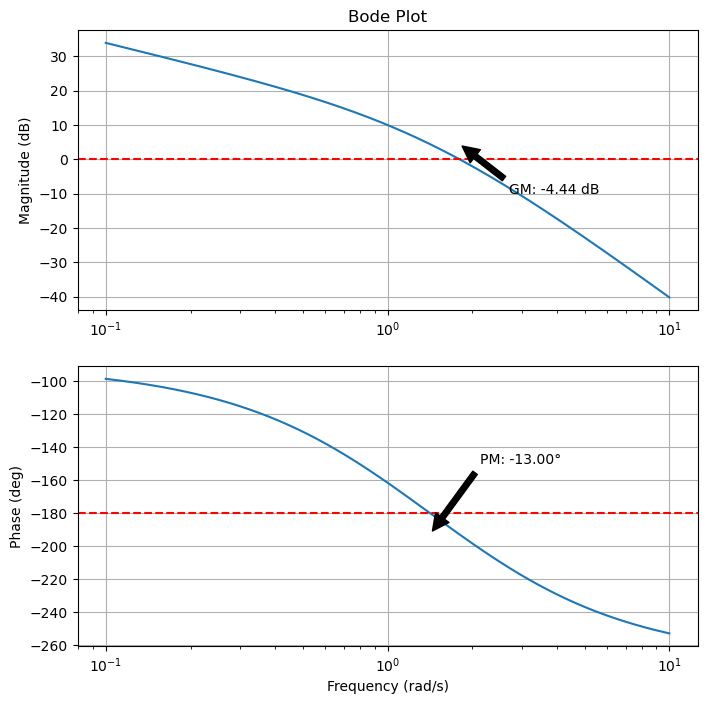

In [21]:
import control as ct
import matplotlib.pyplot as plt

# Define open-loop transfer function G(s) = 10 / [s(s+1)(s+2)]
G = ct.tf([10], [1, 3, 2, 0])  # Denominator: s^3 + 3s^2 + 2s

# Compute stability margins
gm, pm, wg, wp = ct.margin(G)
print(f'Gain Margin: {gm:.2f} (linear), {20 * np.log10(gm):.2f} dB')
print(f'Phase Margin: {pm:.2f} degrees')
print(f'Gain Crossover Frequency: {wg:.2f} rad/s')
print(f'Phase Crossover Frequency: {wp:.2f} rad/s')

# Bode plot
mag, phase, omega = ct.bode(G, dB=True, Hz=False, plot=False)

# Plot manually for customization
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(8, 8))
ax_mag.semilogx(omega, 20 * np.log10(mag))
ax_mag.set_title('Bode Plot')
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.grid(True)

ax_phase.semilogx(omega, np.degrees(phase))
ax_phase.set_xlabel('Frequency (rad/s)')
ax_phase.set_ylabel('Phase (deg)')
ax_phase.grid(True)

# Annotate margins
ax_mag.axhline(0, color='r', linestyle='--')  # 0 dB line
ax_phase.axhline(-180, color='r', linestyle='--')  # -180° line
ax_mag.annotate(f'GM: {20 * np.log10(gm):.2f} dB', xy=(wp, 20 * np.log10(1/gm)), xytext=(wp*1.5, -10),
                arrowprops=dict(facecolor='black', shrink=0.05))
ax_phase.annotate(f'PM: {pm:.2f}°', xy=(wg, np.degrees(phase[np.argmin(np.abs(mag - 1))])), xytext=(wg*1.5, -150),
                  arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## 3. PID Controllers

Proportional-Integral-Derivative (PID) controllers are among the most widely used feedback mechanisms in control engineering due to their simplicity, effectiveness, and tunability. They combine three actions to compute the control signal based on the error $e(t)$:

- **Proportional (P)** action: Responds to the current error magnitude, providing immediate correction. It improves responsiveness (e.g., faster rise time) but can lead to steady-state error if used alone. Mathematically, $u_P(t) = K_p e(t)$, where $K_p$ is the proportional gain.
- **Integral (I)** action: Accumulates past errors to eliminate steady-state offsets, ideal for rejecting constant disturbances. It can cause overshoot or instability if over-tuned due to "windup." Term: $u_I(t) = K_i \int_0^t e(\tau) \, d\tau$.
- **Derivative (D)** action: Predicts future error trends based on the rate of change, adding damping to reduce overshoot and oscillations. Sensitive to noise, so often filtered. Term: $u_D(t) = K_d \frac{de(t)}{dt}$.

The full PID controller in the time domain is $u(t) = K_p e(t) + K_i \int_0^t e(\tau) \, d\tau + K_d \frac{de(t)}{dt}$, with Laplace transfer function:

$$C(s) = K_p + \frac{K_i}{s} + K_d s.$$

Trade-offs include balancing responsiveness (high $K_p$) with stability (moderate $K_d$) and offset elimination (appropriate $K_i$), often requiring tuning to avoid instability or sluggishness. In space applications, PID is used for reaction wheel control in satellite attitude systems: P for quick alignment, I to counter persistent torques (e.g., from solar pressure), and D to damp nutation modes, ensuring precise pointing for communications or imaging.


### 3.1 Implementing P control in Python
Proportional control is the simplest form, using only $C(s) = K_p$. We'll simulate it on the second-order plant $G(s) = \frac{1}{s^2 + s + 1}$ from Section 1.4, showing step responses for different $K_p$ values to illustrate increased speed but potential overshoot.




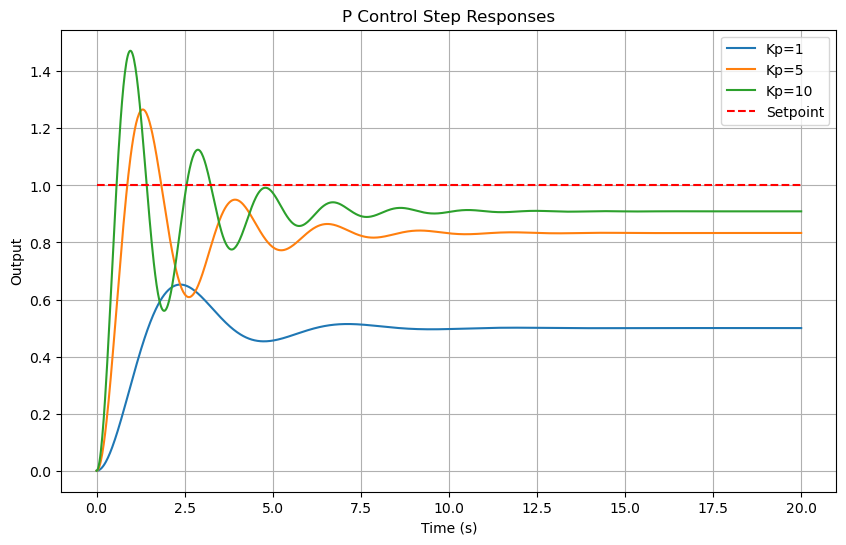

In [22]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Plant
G = ct.tf([1], [1, 1, 1])

# Simulation time
t = np.linspace(0, 20, 1000)

# Function to simulate P control
def simulate_p(Kp):
    C = ct.tf([Kp], [1])
    sys_cl = ct.feedback(C * G, 1)
    t_out, y_out = ct.step_response(sys_cl, t)
    return t_out, y_out

# Plot for different Kp
plt.figure(figsize=(10, 6))
for Kp in [1, 5, 10]:
    t_out, y_out = simulate_p(Kp)
    plt.plot(t_out, y_out, label=f'Kp={Kp}')
plt.plot(t, np.ones_like(t), 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('P Control Step Responses')
plt.legend()
plt.grid(True)
plt.show()

Higher $K_p$ reduces rise time but increases overshoot, risking instability at very high gains.

### 3.2 ImplementingPI control in Python

Adding integral action ($C(s) = K_p + \frac{K_i}{s}$) eliminates steady-state error. Simulate with fixed $K_p = 5$ and varying $K_i$, observing improved tracking but potential overshoot from integration.

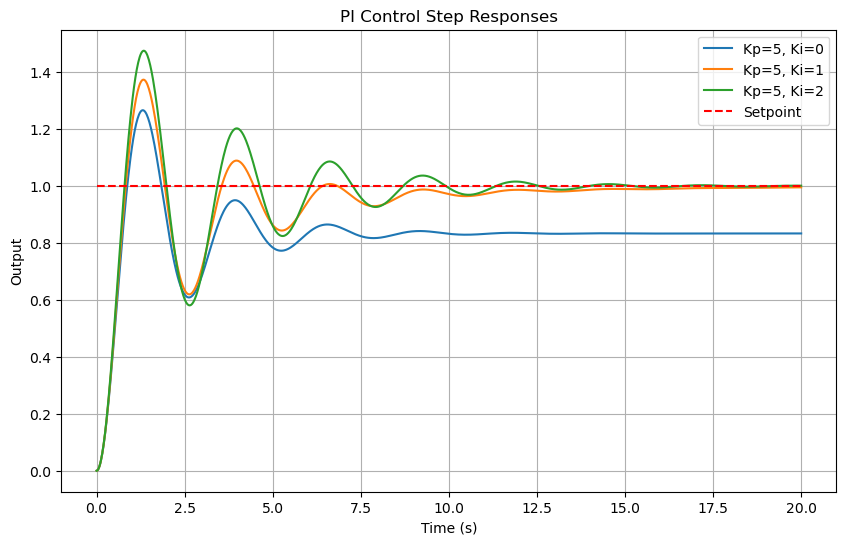

In [23]:
# Function to simulate PI control
def simulate_pi(Kp, Ki):
    C = ct.tf([Kp, Ki], [1, 0])  # Kp s + Ki / s
    sys_cl = ct.feedback(C * G, 1)
    t_out, y_out = ct.step_response(sys_cl, t)
    return t_out, y_out

# Plot for different Ki (fixed Kp=5)
plt.figure(figsize=(10, 6))
for Ki in [0, 1, 2]:
    t_out, y_out = simulate_pi(5, Ki)
    plt.plot(t_out, y_out, label=f'Kp=5, Ki={Ki}')
plt.plot(t, np.ones_like(t), 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('PI Control Step Responses')
plt.legend()
plt.grid(True)
plt.show()

With $K_i > 0$, steady-state error vanishes, but higher $K_i$ may cause more overshoot.

### 3.3 Implementing PID control in Python

Full PID ($C(s) = K_p + \frac{K_i}{s} + K_d s$) combines all actions. Below, static simulations for various gains, followed by interactive tuning using ipywidgets for hands-on exploration.


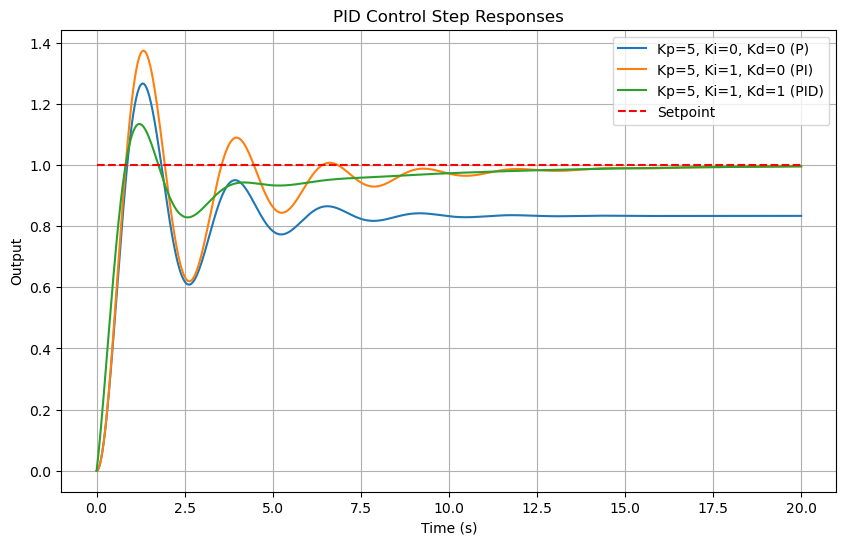

In [24]:
# Function to simulate PID control
def simulate_pid(Kp, Ki, Kd):
    C = ct.tf([Kd, Kp, Ki], [1, 0])  # Kd s^2 + Kp s + Ki / s
    sys_cl = ct.feedback(C * G, 1)
    t_out, y_out = ct.step_response(sys_cl, t)
    return t_out, y_out

# Plot for example gains
plt.figure(figsize=(10, 6))
labels = ['Kp=5, Ki=0, Kd=0 (P)', 'Kp=5, Ki=1, Kd=0 (PI)', 'Kp=5, Ki=1, Kd=1 (PID)']
for i, (Kp, Ki, Kd) in enumerate([(5,0,0), (5,1,0), (5,1,1)]):
    t_out, y_out = simulate_pid(Kp, Ki, Kd)
    plt.plot(t_out, y_out, label=labels[i])
plt.plot(t, np.ones_like(t), 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('PID Control Step Responses')
plt.legend()
plt.grid(True)
plt.show()

#### Interactive tuning:

Adjust sliders to see effects: e.g., increase $K_d$ for damping, $K_i$ for zero error. In space reaction wheel control, tune for minimal fuel use while maintaining stability.

In [25]:
from ipywidgets import interact, FloatSlider

@interact(Kp=FloatSlider(min=0, max=20, step=0.5, value=5),
          Ki=FloatSlider(min=0, max=5, step=0.1, value=1),
          Kd=FloatSlider(min=0, max=5, step=0.1, value=1))
def interactive_pid(Kp, Ki, Kd):
    t_out, y_out = simulate_pid(Kp, Ki, Kd)
    plt.figure(figsize=(8, 5))
    plt.plot(t_out, y_out, label='Output')
    plt.plot(t_out, np.ones_like(t_out), 'r--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Output')
    plt.title(f'PID: Kp={Kp}, Ki={Ki}, Kd={Kd}')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 2)
    plt.show()

interactive(children=(FloatSlider(value=5.0, description='Kp', max=20.0, step=0.5), FloatSlider(value=1.0, des…

## 4. Tuning Methods: Root-Locus

The root-locus method is a graphical technique for analyzing how the poles of a closed-loop system move in the complex s-plane as a system parameter—typically the controller gain $K$—varies from 0 to $\infty$. This is particularly useful for tuning classical controllers like PID to achieve desired performance specifications, such as stability, damping, and response speed. In space engineering, root-locus is applied to systems like satellite attitude control or orbital maneuvering, where understanding pole migration helps ensure robust performance against perturbations.
Root-Locus Technique
In a unity-feedback system with open-loop transfer function $G(s) = K \cdot G_p(s)$ (where $G_p(s)$ is the plant and compensator), the closed-loop poles satisfy the characteristic equation $1 + G(s) = 0$, or $G(s) = -1$. The root-locus plots the solutions (roots) as $K$ varies.
Key rules for sketching the root-locus (Evans' method):

- Number of branches: Equal to the number of open-loop poles.
- Starting points: At open-loop poles (when $K=0$).
- Ending points: At open-loop zeros or infinity (as $K \to \infty$).
- Real-axis segments: Loci lie on the real axis to the left of an odd number of poles + zeros.
- Asymptotes: For large $s$, branches approach lines at angles $\frac{(2k+1)\pi}{p - z}$ (k=0,1,...), centered at $\frac{\sum p_i - \sum z_i}{p - z}$, where $p, z$ are numbers of poles and zeros.
- Departure/arrival angles: From poles: 180° divided among branches; to zeros: similar but opposite.
- Breakaway/break-in points: Where branches meet/leave the real axis, found by solving $\frac{dK}{ds} = 0$.


Crossover with imaginary axis: Stability boundary, solved via Routh-Hurwitz or auxiliary equation.

These rules allow hand-sketching for intuition, but computational tools like Python's control library automate plotting.

### Tuning for Desired Specifications

Tuning involves selecting $K$ (or PID gains) to place poles at locations yielding desired damping ratio $\zeta$ (e.g., 0.7 for ~4.3% overshoot) and natural frequency $\omega_n$ (for settling time ~$4/(\zeta \omega_n)$). For a second-order system, poles are at $-\zeta \omega_n \pm j \omega_n \sqrt{1 - \zeta^2}$; $\zeta = 0.7$ corresponds to poles at ~45° from the negative real axis.

In space dynamics, double-integrator plants ($G_p(s) = 1/s^2$) model acceleration-controlled systems like thruster-based position control in spacecraft rendezvous. PD control ($C(s) = K_p + K_d s$) stabilizes it by placing poles appropriately.

### Python Implementation
Use ct.root_locus to plot loci. Here's an example for a plant $G_p(s) = \frac{1}{s^2 + s + 1}$ with proportional control ($C(s) = K$):

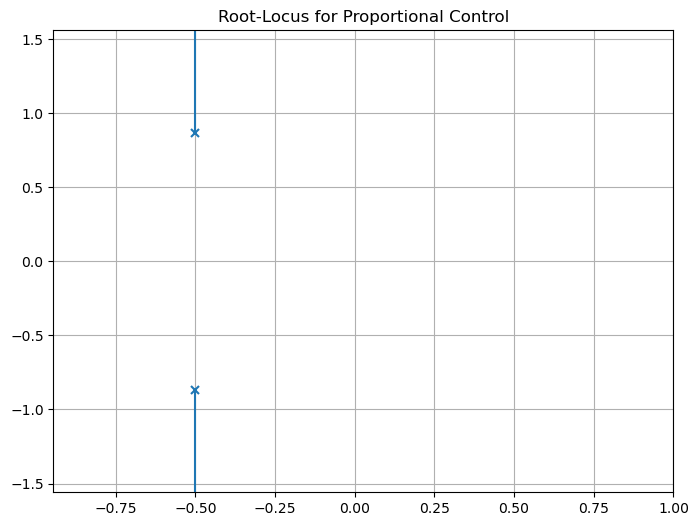

In [26]:
import control as ct
import matplotlib.pyplot as plt

# Plant
G_p = ct.tf([1], [1, 1, 1])

# Root-locus for proportional control (K varies)
fig, ax = plt.subplots(figsize=(8, 6))
ct.root_locus(G_p, ax=ax)  # Plots for L(s) = K G_p(s)
plt.title('Root-Locus for Proportional Control')
plt.grid(True)
plt.show()

The plot shows branches starting at open-loop poles ($-0.5 \pm j \sqrt{0.75}$) and going to infinity along asymptotes. Select $K$ where a branch intersects the desired $\zeta = 0.7$ line (use ct.rlocus with plot=True and zoom interactively in notebooks).

For PD tuning on double-integrator:

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


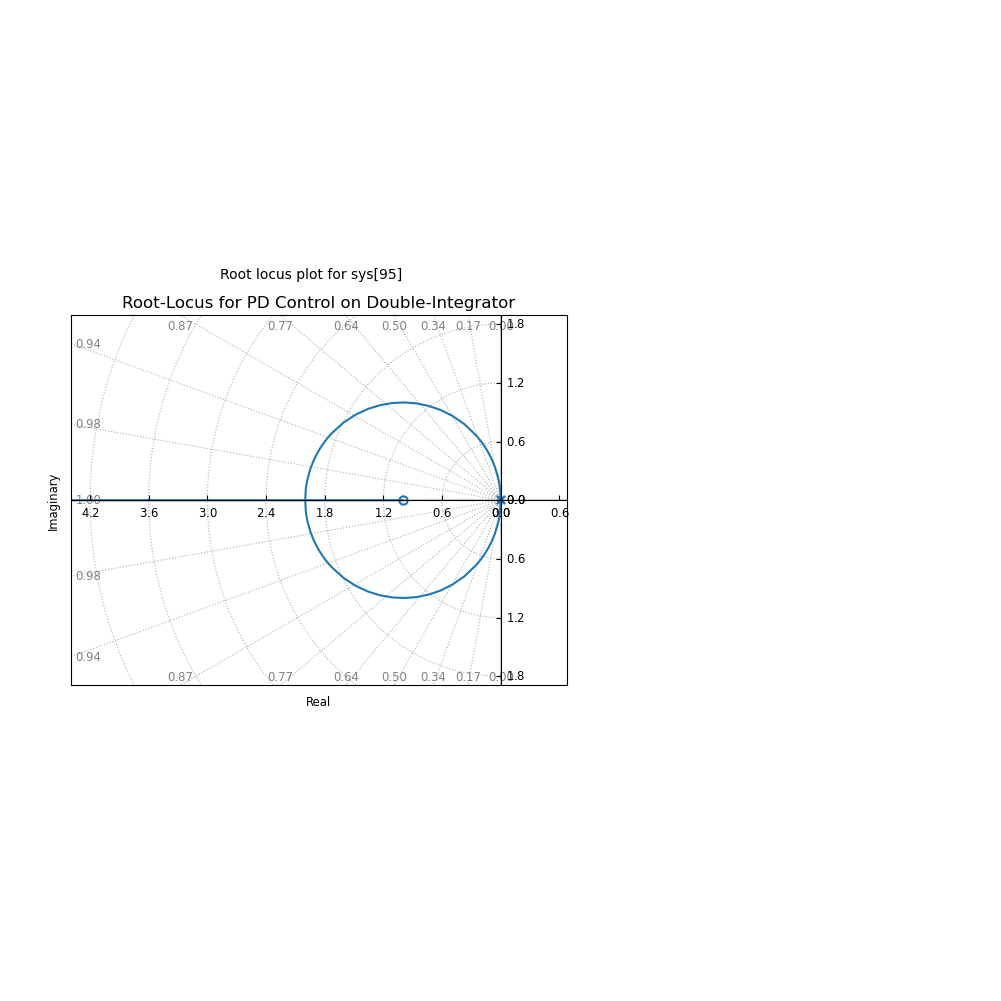

In [27]:
# Double-integrator plant (e.g., spacecraft position)
G_di = ct.tf([1], [1, 0, 0])  # 1/s^2

# PD controller: C(s) = Kp + Kd s = Kd (s + Kp/Kd)
# Let z = Kp/Kd (zero location), vary K = Kd
z = 1  # Example zero at -1
C_pd = ct.tf([1, z], [1])  # (s + z)

# Root-locus (vary K in L(s) = K C_pd G_di)
ct.root_locus(C_pd * G_di)
plt.title('Root-Locus for PD Control on Double-Integrator')
plt.grid(True)
plt.show()

Branches start at (0,0) double pole, one to -z, others to infinity. Tune K for poles at desired $\zeta, \omega_n$.

To find exact K for specs, use ct.root_locus with interactive selection or solve magnitude/angle conditions.

### Exercises on Tuning PD/PID for Double-Integrator Plants

For the double-integrator $G(s) = 1/s^2$, design a PD controller to achieve $\zeta = 0.7$, $\omega_n = 2$ rad/s.
Desired poles: $-1.4 \pm j 1.428$.
Use root-locus to find K_d (gain), z = K_p / K_d.
Hint: Characteristic eq. $s^2 + K_d s + K_p = 0$, so match to $s^2 + 2\zeta\omega_n s + \omega_n^2$: K_d = 2.8, K_p = 4.
Simulate:

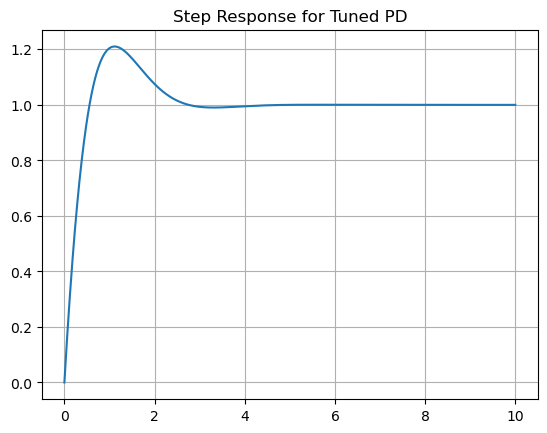

In [28]:
Kp, Kd = 4, 2.8
C_pd = ct.tf([Kd, Kp], [1])
sys_cl = ct.feedback(C_pd * G_di, 1)
t = np.linspace(0, 10, 1000)
t_out, y_out = ct.step_response(sys_cl, t)
plt.plot(t_out, y_out)
plt.title('Step Response for Tuned PD')
plt.grid(True)
plt.show()

Verify overshoot ~4%, settling ~2s.

Extend to PID for double-integrator with disturbance rejection: Add I term, tune to place third pole far left (e.g., -10) while maintaining $\zeta=0.7$.
Application: Model spacecraft as $G(s) = 1/(m s^2)$ (m=1000 kg), tune PD for thrust control to $\zeta=0.707$, $\omega_n=0.1$ rad/s. Simulate with initial position error.

These exercises reinforce tuning for space systems, where double-integrators approximate low-thrust dynamics.

## 5. Tuning Methods: Frequency Domain

Frequency-domain tuning methods, such as Bode plot analysis and empirical rules like Ziegler-Nichols, provide powerful tools for designing and refining controllers by examining the system's response in terms of magnitude and phase across frequencies. These approaches are especially valuable in engineering contexts where physical systems exhibit complex dynamics, such as resonances, delays, or uncertainties. In space engineering, for instance, satellite attitude control systems must handle flexible modes (e.g., solar panel vibrations) or orbital perturbations (e.g., gravitational gradients or atmospheric drag in low Earth orbit). Physically, the Bode plot reflects how energy is amplified or attenuated at different oscillation rates ($  \omega  $), corresponding to natural frequencies of the system—e.g., the resonant frequency of a spacecraft's structure where small inputs could lead to large amplitudes if not damped. Stability margins (GM and PM) quantify robustness: a low PM might result in excessive ringing (overshoot) due to insufficient damping, while inadequate GM could allow parameter drifts (e.g., fuel consumption changing mass properties) to push the system into instability. By tuning in the frequency domain, engineers ensure the controller compensates for these physical effects, maintaining precise pointing or trajectory despite real-world variabilities.




### 5.1 Bode-Based Tuning

Bode plots display magnitude (dB) and phase (degrees) vs. frequency ($\omega$), allowing gain adjustments to meet specifications like GM > 6 dB and PM > 45° (for good damping, low overshoot). For a PID controller, tune $K_p, K_i, K_d$ to shift crossover frequencies and margins:

- Increase $K_p$: Boosts low-frequency gain, raising $\omega_{gc}$, potentially reducing PM but improving bandwidth.
- Add $K_i$: Enhances low-frequency gain (integrator adds -90° phase, +20 dB/decade slope), eliminates steady-state error but may decrease PM if too high.
- Add $K_d$: Boosts high-frequency gain (differentiator adds +90° phase, -20 dB/decade slope), increases PM by countering phase lag.

Process: Plot open-loop $G(s) C(s)$, adjust gains iteratively to achieve targets. In space applications, this ensures vibration suppression in flexible appendages.
Example with plant $G(s) = \frac{1}{s^2 + s + 1}$, tune P controller for PM ≈ 60°:

/home/endres/anaconda3/envs/comp_eng/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


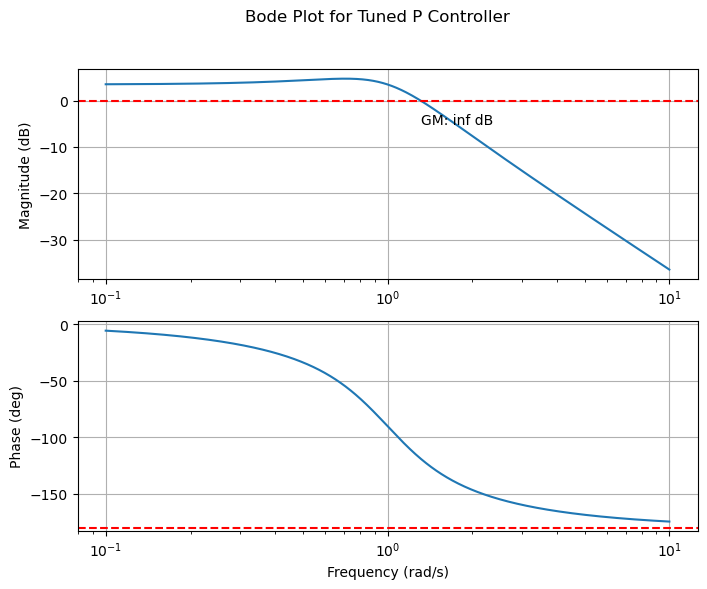

In [29]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Plant
G = ct.tf([1], [1, 1, 1])

# Initial proportional gain
Kp = 1.5  # Adjust to meet PM ~60°

# Open-loop
OL = Kp * G

# Bode plot
mag, phase, omega = ct.bode(OL, dB=True, plot=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.semilogx(omega, 20 * np.log10(mag))
ax1.set_ylabel('Magnitude (dB)')
ax1.grid(True)

ax2.semilogx(omega, phase * 180 / np.pi)
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Frequency (rad/s)')
ax2.grid(True)

# Compute and annotate margins
gm, pm, wg, wp = ct.margin(OL)
ax1.axhline(0, color='r', ls='--')
ax2.axhline(-180, color='r', ls='--')
ax1.text(wp, -5, f'GM: {20*np.log10(gm):.1f} dB')
ax2.text(wg, -120, f'PM: {pm:.1f}°')

plt.suptitle('Bode Plot for Tuned P Controller')
plt.show()

### 5.2 Ziegler-Nichols Method

The Ziegler-Nichols (ZN) method is a practical empirical technique for tuning PID controllers, widely used in engineering to achieve acceptable performance with minimal trial-and-error. In the context of space engineering, ZN is valuable for systems like satellite attitude control (where PID might regulate reaction wheels to counter gravitational torques) or thermal management (controlling heaters to maintain instrument temperatures despite varying solar exposure). Physically, it exploits the system's natural resonance by pushing it to marginal stability, revealing inherent time scales and gains that reflect the plant's inertia, damping, and stiffness—key in modeling spacecraft dynamics under Newton's laws or heat transfer equations.


Overview of steps:

- Set $K_i = K_d = 0$, increase $K_p$ until sustained oscillations ($K_p = K_u$).
- Measure $P_u$ from response.
- Apply rules to tune the controller (see for example the table below).


To clarify the setup, consider a unity-feedback closed-loop system. The plant transfer function is $G(s)$, and the PID controller is $C(s) = K_p + \frac{K_i}{s} + K_d s$. The open-loop transfer function is $L(s) = C(s) G(s)$, and the closed-loop transfer function from reference $R(s)$ to output $Y(s)$ is:

$$\frac{Y(s)}{R(s)} = \frac{L(s)}{1 + L(s)}.$$

Stability depends on the roots of the characteristic equation $1 + L(s) = 0$. ZN tunes by first using P-only control ($K_i = K_d = 0$) to find the gain $K_u$ where roots cross the imaginary axis (sustained oscillations), then applies rules to set all gains for desired damping and response.
We'll demonstrate using the plant $G(s) = \frac{1}{(s+1)^3}$, modeling a lagged process like thermal response in a spacecraft module (three time constants from heat capacities and resistances).


> #### Example: Demonstration of PID tuning
> Before tuning, explore how arbitrary (untuned) PID gains affect the response. This highlights poor choices (e.g., low gains lead to sluggishness and error; high gains cause instability), relating to engineering trade-offs: insufficient $K_p$ might fail to counter orbital disturbances quickly, while excessive $K_d$ amplifies sensor noise in space environments.
> The interactive plot below allows tuning all parameters ($K_p, K_i, K_d$) to see effects—try low values for "worse" performance (slow rise, persistent error) vs. better but unstable settings.

In [48]:
from ipywidgets import interact, FloatSlider
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Plant: G(s) = 1 / (s+1)^3
G = ct.tf([1], [1, 3, 3, 1])

# Simulation time
t = np.linspace(0, 50, 1000)

# Interactive function for untuned PID
@interact(Kp=FloatSlider(min=0, max=10, step=0.1, value=1.0, description='Kp'),
          Ki=FloatSlider(min=0, max=5, step=0.1, value=0.0, description='Ki'),
          Kd=FloatSlider(min=0, max=5, step=0.1, value=0.0, description='Kd'))
def plot_untuned(Kp, Ki, Kd):
    C_untuned = ct.tf([Kd, Kp, Ki], [1, 0]) if Ki > 0 or Kd > 0 else ct.tf([Kp], [1])
    sys_untuned = ct.feedback(C_untuned * G, 1)
    t_out, y_out = ct.step_response(sys_untuned, t)

    plt.figure(figsize=(8, 5))
    plt.plot(t_out, y_out, label=f'Untuned (Kp={Kp}, Ki={Ki}, Kd={Kd})')
    plt.plot(t_out, np.ones_like(t_out), 'r--', label='Setpoint')
    plt.title('Interactive Step Response for Untuned PID Controller')
    plt.xlabel('Time (s)')
    plt.ylabel('Output')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 2)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='Kp', max=10.0), FloatSlider(value=0.0, description='…

### Code to Find $K_u$

ZN starts with P-only control: increase $K_p$ until oscillations sustain ($K_p = K_u$). Use binary search for precision, finding where GM ≈ 1.

In [41]:
# Function to find Ku using binary search
def find_ku(G, K_low=0, K_high=100, tol=1e-3):
    while K_high - K_low > tol:
        K_mid = (K_low + K_high) / 2
        OL = K_mid * G
        gm, _, _, _ = ct.margin(OL)
        if gm > 1:  # Stable, increase K
            K_low = K_mid
        else:  # Unstable or marginal, decrease K
            K_high = K_mid
    return K_high

Ku = find_ku(G)
print(f'Ultimate gain Ku ≈ {Ku:.2f}')

Ultimate gain Ku ≈ 8.00


This yields $K_u \approx 8.00$.

### Oscillating Output at $K_u$

Simulate at $K_u$ to observe oscillations and extract $P_u$.

Oscillation period Pu ≈ 3.65 s


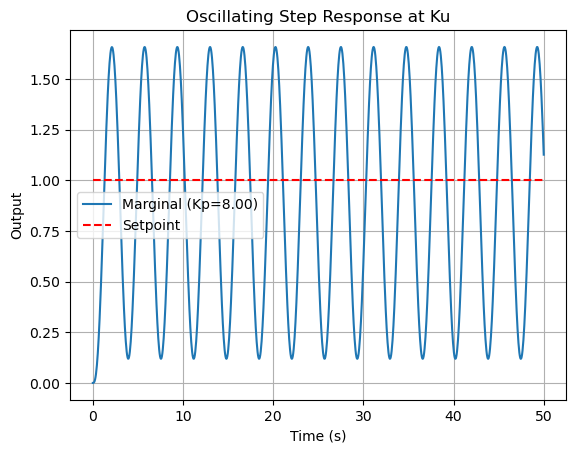

In [42]:
from scipy.signal import find_peaks

# Controller at Ku
C_ku = ct.tf([Ku], [1])
sys_marg = ct.feedback(C_ku * G, 1)

# Step response
t_out, y_marg = ct.step_response(sys_marg, t)

# Find Pu from peaks
peaks, _ = find_peaks(y_marg)
if len(peaks) >= 2:
    Pu = t_out[peaks[1]] - t_out[peaks[0]]
    print(f'Oscillation period Pu ≈ {Pu:.2f} s')

# Plot
plt.plot(t_out, y_marg, label=f'Marginal (Kp={Ku:.2f})')
plt.plot(t_out, np.ones_like(t_out), 'r--', label='Setpoint')
plt.title('Oscillating Step Response at Ku')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
z

$P_u \approx 3.65$ s.

### Applying the Rules

The table lists all ZN variants:


| Controller Type          | $K_p $     | $T_i $     | $T_d $     | $K_i = K_p / T_i $ | $K_d = K_p \cdot T_d $ |
|--------------------------|---------------|---------------|---------------|-----------------------|---------------------------|
| P                       | $0.5 K_u $ | -             | -             | -                     | -                         |
| PI                      | $0.45 K_u $| $P_u / 1.2 $| -             | $K_p / T_i $       | -                         |
| PID (Classic)           | $0.6 K_u $ | $P_u / 2 $ | $P_u / 8 $ | $K_p / T_i $       | $K_p \cdot T_d $       |
| PID (Some Overshoot)    | $0.33 K_u $| $P_u / 2 $ | $P_u / 3 $ | $K_p / T_i $       | $K_p \cdot T_d $       |
| PID (No Overshoot)      | $0.2 K_u $ | $P_u / 2 $ | $P_u / 3 $ | $K_p / T_i $       | $K_p \cdot T_d $       |


For classic PID: $K_p = 4.8$, $T_i = 1.825$, $T_d = 0.456$, $K_i = 2.63$, $K_d = 2.19$.


### Output of the Final Tuned Controller
The tuned PID eliminates error and speeds response, better than untuned despite overshoot (refine for space applications).
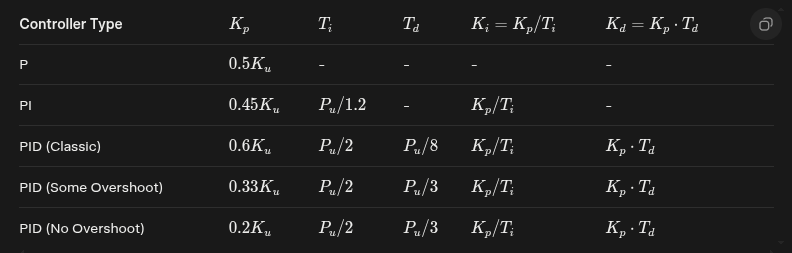
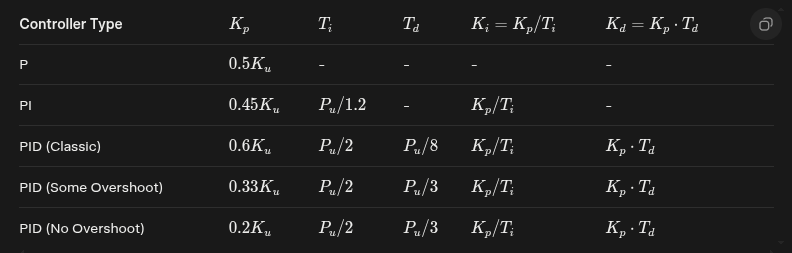

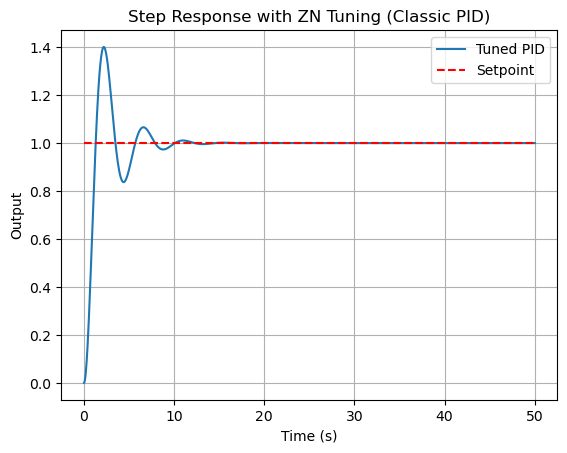

In [43]:
# ZN PID (classic)
Kp_zn = 0.6 * Ku
Ti_zn = Pu / 2
Td_zn = Pu / 8
Ki_zn = Kp_zn / Ti_zn
Kd_zn = Kp_zn * Td_zn

C_zn = ct.tf([Kd_zn, Kp_zn, Ki_zn], [1, 0])
sys_zn = ct.feedback(C_zn * G, 1)

t_out, y_out = ct.step_response(sys_zn, t)

plt.plot(t_out, y_out, label='Tuned PID')
plt.plot(t_out, np.ones_like(t_out), 'r--', label='Setpoint')
plt.title('Step Response with ZN Tuning (Classic PID)')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

Other variants:

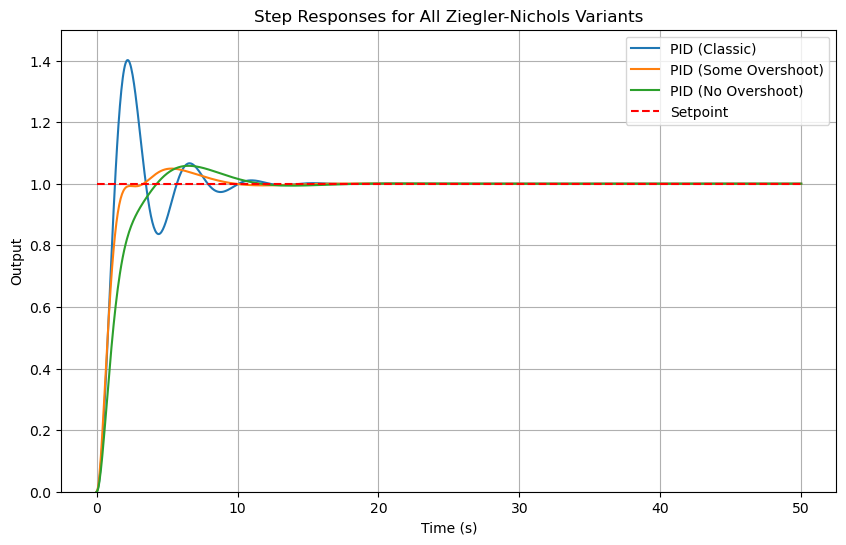

In [44]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Plant: G(s) = 1 / (s+1)^3
G = ct.tf([1], [1, 3, 3, 1])

# Simulation time
t = np.linspace(0, 50, 1000)

# ZN parameters
Ku = 8.0
Pu = 3.65

# Function to get controller and simulate
def get_zn_response(label, Kp_factor, Ti_factor, Td_factor):
    Kp = Kp_factor * Ku
    if Ti_factor is not None:
        Ti = Pu / Ti_factor
        Ki = Kp / Ti
    else:
        Ki = 0
    if Td_factor is not None:
        Td = Pu / Td_factor
        Kd = Kp * Td
    else:
        Kd = 0
    C = ct.tf([Kd, Kp, Ki], [1, 0]) if Ki > 0 or Kd > 0 else ct.tf([Kp], [1])
    sys = ct.feedback(C * G, 1)
    t_out, y_out = ct.step_response(sys, t)
    return label, t_out, y_out

# Collect responses
responses = [
    #get_zn_response('P', 0.5, None, None),
    #get_zn_response('PI', 0.45, 1.2, None),
    get_zn_response('PID (Classic)', 0.6, 2, 8),
    get_zn_response('PID (Some Overshoot)', 0.33, 2, 3),
    get_zn_response('PID (No Overshoot)', 0.2, 2, 3)
]

# Plot all
plt.figure(figsize=(10, 6))
for label, t_out, y_out in responses:
    plt.plot(t_out, y_out, label=label)
plt.plot(t, np.ones_like(t), 'r--', label='Setpoint')
plt.title('Step Responses for All Ziegler-Nichols Variants')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.5)
plt.show()

### Handling Time Delays

Time delays (e.g., actuator lags in spacecraft) are modeled as $e^{-T_d s}$, destabilizing by adding phase lag. Use Padé approximation (e.g., 1st-order: $\frac{1 - (T_d/2) s}{1 + (T_d/2) s}$) for rational transfer functions. Tune conservatively, reducing gains to maintain PM.

Example: Add delay $T_d = 0.5$ s to plant.

In [45]:
# Padé approx for delay
num_pade, den_pade = ct.pade(0.5, 1)
delay_approx = ct.tf(num_pade, den_pade)
G_delay = G * delay_approx

# Retune using ZN or Bode on G_delay
Ku_delay = find_ku(G_delay)
# Proceed similarly...

Delays lower Ku, requiring detuning for stability.

### Comparison with Root-Locus

Root-locus excels in pole placement for transient specs (e.g., $\zeta, \omega_n$), ideal for known-order systems, but less direct for margins. Frequency-domain (Bode/ZN) focuses on robustness (GM/PM) and handles delays/non-minimum phase easily via plots, without solving roots. Use root-locus for initial design, Bode for verification/refinement. In space dynamics, root-locus suits rigid-body models; frequency-domain for flexible modes with resonances.

## 6. Summary

This chapter has provided an introduction to classical feedback control, emphasizing computational tools and practical applications in space engineering. We began with the fundamentals of open-loop versus closed-loop systems, highlighting feedback as an error-correction mechanism that enhances robustness in dynamic environments, such as satellite attitude adjustment under disturbances like solar radiation pressure. The historical overview traced the evolution from mechanical governors to mathematical frameworks, underscoring how wartime innovations in electronic servomechanisms laid the groundwork for modern control.

The Laplace transform was introduced as a key tool for converting time-domain differential equations into algebraic forms in the s-domain, enabling easier analysis of linear systems—like solving ODEs for mass-spring-damper models representative of spacecraft vibrations. We explored control loop anatomy, including components like sensors, actuators, and the plant, with block diagrams illustrating signal flow and performance metrics (e.g., rise time, overshoot) critical for evaluating responses in orbital maneuvers.

Basic simulations demonstrated the benefits of feedback, such as reduced steady-state error in proportional control for thruster-based orbit adjustments. Stability concepts, including BIBO and asymptotic stability, were analyzed via pole locations in the s-domain, using tools like Routh-Hurwitz for robustness checks. Frequency-domain margins (GM and PM) were introduced to quantify proximity to instability, essential for systems with uncertainties like variable gravitational fields.

PID controllers were detailed, with their actions (P for responsiveness, I for error elimination, D for damping) and transfer function $C(s) = K_p + \frac{K_i}{s} + K_d s$, applied to space scenarios like reaction wheel control. Python implementations showed how to simulate and interactively tune these.

Tuning methods wrapped up the chapter: root-locus for visualizing pole trajectories and achieving desired damping (e.g., $\zeta = 0.7$) in double-integrator plants common in space dynamics, and frequency-domain techniques like Bode-based adjustments and Ziegler-Nichols for empirical gain setting, handling delays in deep-space communications.

While classical methods excel in SISO systems and provide intuitive design via graphical tools, they have limitations: difficulty scaling to MIMO systems, reliance on linear approximations (ignoring nonlinearities like actuator saturation in rockets), and challenges with time-varying or uncertain parameters. These shortcomings motivate the shift to state-space methods in the next chapter, which offer a more unified framework for multivariable control, observer design, and optimal strategies like LQR, better suited for complex spacecraft systems integrating multiple sensors and actuators.



## Further reading

For deeper exploration, consult the following textbooks and seminal papers, selected for their relevance to the chapter's subsections. These resources provide theoretical depth and historical context, with computational examples often adaptable to Python for numerical verification in space engineering applications.

**Textbooks**


- Feedback Control of Dynamic Systems by Gene F. Franklin, J. David Powell, and Abbas Emami-Naeini (8th ed., 2019): Comprehensive coverage of classical control, including Laplace transforms, stability, PID, root-locus, and frequency-domain design; strong on examples like satellite control.
- - Process Dynamics and Control by Dale E. Seborg, Thomas F. Edgar, Duncan A. Mellichamp, and Francis J. Doyle III (4th ed., 2017): Focuses on PID tuning and frequency-domain methods, with applications to dynamic processes relevant to engineering systems (Chemical Engineering focus).
- Modern Control Engineering by Katsuhiko Ogata (5th ed., 2009): Excellent for root-locus and Bode methods, with engineering applications.
- Control Systems Engineering by Norman S. Nise (8th ed., 2020): Practical focus on PID tuning and simulations, ideal for computational exercises.
- Automatic Control Systems by Benjamin C. Kuo and Farid Golnaraghi (10th ed., 2017): Detailed on classical techniques with space-related examples.

**Seminal Papers** (Grouped by Subsection)

These papers, many collected in anthologies like Classic Papers in Control Theory (ed. Richard Bellman and Robert Kalaba, 1978; Dover reprint 2017), form the foundation of the topics discussed.

Introduction to Feedback Control and History:

- J. C. Maxwell, "On Governors" (1868): Early analysis of stability in mechanical feedback systems like steam engines.
- H. S. Black, "Stabilized Feedback Amplifiers" (1934): Introduced negative feedback for distortion reduction in electronics.
- N. Minorsky, "Directional Stability of Automatically Steered Bodies" (1922): Applied feedback to ship steering, foundational for autopilots.

The Laplace Transform:

- O. Heaviside, "Electromagnetic Induction and Its Propagation" (1887): Popularized operational calculus (precursor to Laplace in engineering).
- H. Bateman, "The Control of an Elastic Fluid" (1929): Early use of transforms for dynamic systems (from Bellman/Kalaba collection).

Control Loop Anatomy and Basic Example:

- H. W. Bode, "Feedback — The History of an Idea" (1960): Discusses loop components and performance in amplifiers.

Stability and Stability in the s-Domain:

- E. J. Routh, "A Treatise on the Stability of a Given State of Motion" (1877): Introduced Routh criterion for stability.
- A. Hurwitz, "On the Conditions Under Which an Equation Has Only Roots with Negative Real Parts" (1895): Complementary to Routh for polynomial stability.
- Richard Bellman and Robert Kalaba, "The Work of Lyapunov and Poincaré" (1960): Overview of stability theory.

Stability Margins:

- H. Nyquist, "Regeneration Theory" (1932): Nyquist criterion for stability margins.
- H. W. Bode, "Relations Between Attenuation and Phase in Feedback Amplifier Design" (1940): Bode plots and gain/phase margins.

PID Controllers:
- J. G. Ziegler and N. B. Nichols, "Optimum Settings for Automatic Controllers" (1942): Original ZN tuning rules.

Tuning Methods: Root-Locus:
- W. R. Evans, "Graphical Analysis of Control Systems" (1948): Introduced root-locus technique.

Tuning Methods: Frequency Domain:
- B. van der Pol, "Forced Oscillations in a Circuit" (1920): Early work on nonlinear oscillations relevant to frequency analysis.
- N. Minorsky, "Self-Excited Oscillations in Dynamical Systems Possessing Retarded Action" (1942): Time delays in control.


For computational perspectives, refer to modern resources like the Python Control Systems Library documentation (control.readthedocs.io) for implementing these concepts in code.
